<a href="https://colab.research.google.com/github/lcjln/Kaggle_Project/blob/main/Titanic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#기본 패키지
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [22]:
#로컬 파일 가져오기
from google.colab import files

uploaded = files.upload()

Saving all_df.csv to all_df.csv


# ML 학습

In [70]:
all_df = pd.read_csv('all_df.csv')
all_df = all_df.drop('Unnamed: 0', axis=1)
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [71]:
all_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,male,22.000000,1,0,7.2500,S,Mr,1,0.0
1,1.0,1,female,38.000000,1,0,71.2833,C,Mrs,1,0.0
2,1.0,3,female,26.000000,0,0,7.9250,S,Miss,0,1.0
3,1.0,1,female,35.000000,1,0,53.1000,S,Mrs,1,0.0
4,0.0,3,male,35.000000,0,0,8.0500,S,Mr,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,32.252151,0,0,8.0500,S,Mr,0,1.0
1305,NaN,1,female,39.000000,0,0,108.9000,C,others,0,1.0
1306,NaN,3,male,38.500000,0,0,7.2500,S,Mr,0,1.0
1307,NaN,3,male,32.252151,0,0,8.0500,S,Mr,0,1.0


In [72]:
# 문자열 데이터 열을 'categories'로 정의
categories = all_df.columns[all_df.dtypes == 'object']
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


라벨 인코딩 : 문자열을 수치로 변환하여 머신러닝 학습 데이터 제작 준비를 한다

In [73]:
from sklearn.preprocessing import LabelEncoder

In [74]:
all_df['Embarked'].fillna("missing", inplace=True)

/tmp/ipython-input-74-343720052.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df['Embarked'].fillna("missing", inplace=True)


In [44]:
all_df.head()

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1,0.0
1,1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1,0.0
2,2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0,1.0
3,3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1,0.0
4,4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0,1.0


In [75]:
le = LabelEncoder()
le = le.fit(all_df['Sex'])
all_df['Sex'] = le.transform(all_df['Sex'])

In [76]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtype == 'object':
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])

Sex
Embarked
honorific


In [47]:
all_df.head()
#모든 열이 숫자형 데이터가 되었음

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0,0.0,3,1,22.0,1,0,7.2500,2,2,1,0.0
1,1,1.0,1,0,38.0,1,0,71.2833,0,3,1,0.0
2,2,1.0,3,0,26.0,0,0,7.9250,2,1,0,1.0
3,3,1.0,1,0,35.0,1,0,53.1000,2,3,1,0.0
4,4,0.0,3,1,35.0,0,0,8.0500,2,2,0,1.0


전체 데이터를 학습 데이터와 테스트 데이터로 분리하기

In [77]:
train_X = all_df[~all_df['Survived'].isnull()].drop('Survived', axis=1).reset_index(drop=True) # Survived를 예측해야 하므로 survived를 제외한 목적변수를 지정
train_Y = train_df['Survived']
test_X = all_df[all_df['Survived'].isnull()].drop('Survived', axis=1).reset_index(drop=True)

LightGBM을 이용하여 예측 모델을 제작한다

In [32]:
!pip install lightgbm==2.3.1

In [33]:
import lightgbm as lgb

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [78]:
# 홀드아웃 학습 데이터 중 20%를 검증 데이터로 나눈다
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

LightGBM용 데이터셋 작성

In [79]:
categories = ['Embarked','Pclass','Sex','honorific', 'alone']

In [80]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categories) #reference 지정 중요

In [81]:
lgbm_params = {
    "objective": "binary",
    'random_seed' : 1234
}

ML 학습

In [82]:
model_lgb = lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      num_boost_round=100,
                      early_stopping_rounds=20,
                      verbose_eval = 10)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.471717
[20]	valid_0's binary_logloss: 0.417166
[30]	valid_0's binary_logloss: 0.401644
[40]	valid_0's binary_logloss: 0.395837
[50]	valid_0's binary_logloss: 0.392129
[60]	valid_0's binary_logloss: 0.394338
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.390116


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


48번 째 학습이 최고 점수를 만들어 내었고

이 모델에 사용된 학습 데이터 중 어떤 설명 변수가 얼만큼의 역할을 했는지 알아보기

In [83]:
model_lgb.feature_importance()

array([ 70,  36, 471,  22,  22, 519,  52,  22,  22,   5], dtype=int32)

<Axes: >

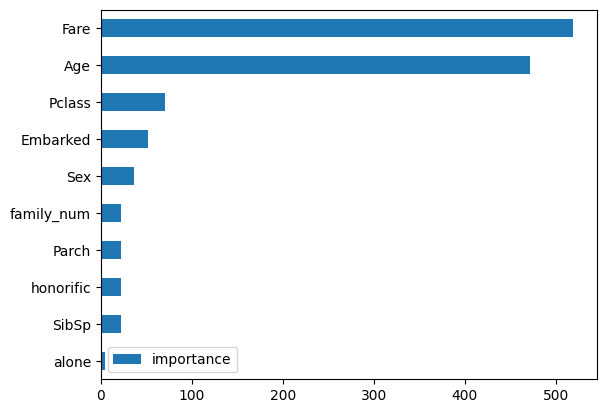

In [87]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=['importance']).sort_values('importance', ascending=True)
importance.plot.barh()

검증 데이터를 이용하여 정확도 계산

In [88]:
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(y_valid, np.round(y_pred))

0.8324022346368715

모델의 정확도는 약 0.8324로 나왔고 하이퍼마라미터를 변경하여 모델을 개선해본다

In [91]:
lgbm_params = {
    'objective' : 'binary',
    'max_bin' : 331,
    'num_leaves' : 20,
    'min_data-in_leaf' : 57,
    'random_seed' : 1234
}

In [94]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categories)

In [95]:
model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    early_stopping_rounds=20,
    verbose_eval=10
)

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.47198
[20]	valid_0's binary_logloss: 0.412722
[30]	valid_0's binary_logloss: 0.400604
[40]	valid_0's binary_logloss: 0.387629
[50]	valid_0's binary_logloss: 0.383384
[60]	valid_0's binary_logloss: 0.377432
[70]	valid_0's binary_logloss: 0.374417
[80]	valid_0's binary_logloss: 0.377751
[90]	valid_0's binary_logloss: 0.379744
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.371633


In [96]:
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [97]:
accuracy_score(y_valid, np.round(y_pred)) # 정확도가 약 0.8548로 상승하였다

0.8547486033519553

교차 검증을 이용한 학습

In [98]:
folds = 3
kf = KFold(n_splits=folds)

In [101]:
#교차학습 데이터 준비
models = []
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index] # 행 조건만 적으면 열은 전체 자동 선택, 하지만 행 조건 생략하고 열 조건만 적는건 에러 발생
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    #모델 학습시키기
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categories)

    model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    early_stopping_rounds=20,
    verbose_eval=10
    )

    #정확도 계산
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    models.append(model_lgb)

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.496542
[20]	valid_0's binary_logloss: 0.477603
[30]	valid_0's binary_logloss: 0.476826
[40]	valid_0's binary_logloss: 0.490374
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.471491
0.797979797979798


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.46324
[20]	valid_0's binary_logloss: 0.423024
[30]	valid_0's binary_logloss: 0.43403
[40]	valid_0's binary_logloss: 0.441745
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.420337
0.8484848484848485
Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.451241
[20]	valid_0's binary_logloss: 0.399594
[30]	valid_0's binary_logloss: 0.385073
[40]	valid_0's binary_logloss: 0.380139
[50]	valid_0's binary_logloss: 0.382813
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.378464
0.8417508417508418


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


테스트 예측 결과 계산

In [102]:
preds=[]
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [103]:
#교차 검증으로 구한 세 개의 모델의 평균 구하기
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [104]:
# 예측 결과가 0.5보다 크면 생존으로 생존(1)으로 예측
preds_int = (preds_mean > 0.5).astype(int)

In [106]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived']=preds_int
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
